## m1: popularity

### Setup

In [19]:
import time
from datetime import timedelta

import pandas as pd
import numpy as np
from scipy import stats

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Model infrastructure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics as sk_metrics

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Reductions
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap

# Regressions
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

### 1. Preprocessing

In [20]:
# Load data
df = pd.read_csv('data/red.csv', parse_dates=['release']).drop(columns=['release'])
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

print(f'Data train: {df_train.shape[0]} rows, {df_train.shape[1]} columns')
print(f'Data test: {df_test.shape[0]} rows, {df_test.shape[1]} columns')

Data train: 12000 rows, 519 columns
Data test: 3000 rows, 519 columns


In [21]:
# Drop NA and zero values
n_orig = df_train.shape[0]
n_na = df_train['popularity'].isna().sum()
df_train = df_train.dropna(subset=['popularity'])
n_zero = df_train.loc[df_train['popularity']==0].shape[0]
df_train = df_train.loc[df_train['popularity']>0]
print(f'Train set: Dropped {n_na} NA entries and {n_zero} zero entries of {n_orig}, {df_train.shape[0]} entries left.')
n_orig = df_test.shape[0]
n_na = df_test['popularity'].isna().sum()
df_test = df_test.dropna(subset=['popularity'])
n_zero = df_test.loc[df_test['popularity']==0].shape[0]
df_test = df_test.loc[df_test['popularity']>0]
print(f'Test set: Dropped {n_na} NA entries and {n_zero} zero entries of {n_orig}, {df_test.shape[0]} entries left.')

Train set: Dropped 0 NA entries and 0 zero entries of 12000, 12000 entries left.
Test set: Dropped 0 NA entries and 0 zero entries of 3000, 3000 entries left.


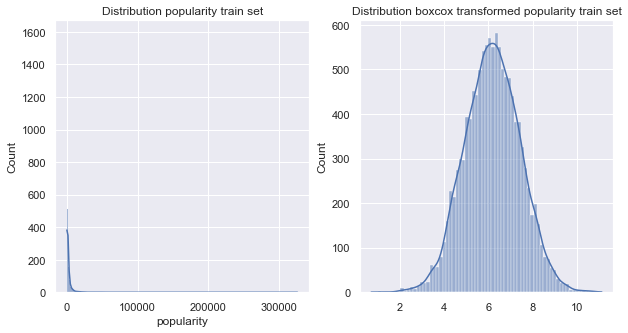

In [17]:
# Boxcox transform y
y_train_before = df_train['popularity']
y_train = stats.boxcox(y_train_before)[0]
y_train = pd.Series(y_train)
y_test_before = df_test['popularity']
y_test = stats.boxcox(y_test_before)[0]
y_test = pd.Series(y_test)
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax1 = sns.histplot(x=y_train_before, kde=True, ax=axs[0])
ax1.set(title="Distribution popularity train set")
ax2 = sns.histplot(x=y_train, kde=True, ax=axs[1])
ax2.set(title="Distribution boxcox transformed popularity train set")
fig;

In [22]:
# Scale X
X_train = df_train.drop(columns=['popularity'])
X_test = df_test.drop(columns=['popularity'])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
print('')
print(f'Scaled train X:\n\tmean: {X_train.mean().tolist()[:5]}...\n\tstd: {X_train.std().tolist()[:5]}...')
print(f'Scaled test X:\n\tmean: {X_test.mean().tolist()[:5]}...\n\tstd: {X_test.std().tolist()[:5]}...')


Scaled train X:
	mean: [-3.552713678800501e-18, -3.552713678800501e-18, 2.0724163126336257e-18, 2.3684757858670005e-18, 1.1842378929335003e-18]...
	std: [1.0000416692710143, 1.0000416692710141, 1.0000416692710143, 1.0000416692710141, 1.0000416692710141]...
Scaled test X:
	mean: [-0.009848415285326853, 0.025932001986916354, -0.01669766657567169, -0.015684474132562635, -0.017362692021673135]...
	std: [0.03731793879740034, 1.0969250891876667, 0.2700605141237755, 0.4090215584813406, 0.22488530280194016]...


### 2. Reductions

In [38]:
# Load data
df = pd.read_csv('data/red.csv',  parse_dates=['release']).drop(columns=['release'])

# Preprocess data
df = df.dropna(subset=['popularity'])
df = df.loc[df['popularity']>0]
df = df.dropna(subset=['popularity'])
X = df.drop(columns=['popularity'])
y = df['popularity'].iloc[X.index]
y = stats.boxcox(y)[0]
y = pd.Series(y)

print(f'Data: {df.shape[0]} rows, {df.shape[1]} columns')

Data: 15000 rows, 519 columns


In [39]:
# Settings
n_feats = [2, 10, 25, 50, 100, 200, 300, 400, 500]
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = {'model':[], 'n_feats':[], 'mean_r2':[], 'mean_mse':[], 'mean_rmse':[], 'mean_mae':[]}

#### Benchmark

In [40]:
st = time.time()
name = 'lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('mod', LinearRegression())
])

parameters = {
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(518)
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:07


#### RFE - random feature elimination

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [ ]:
st = time.time()
name = 'rfe_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_features_to_select': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

#### PCA - principal component analysis

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

In [41]:
st = time.time()
name = 'pca_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(svd_solver='arpack', random_state=1)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:22


#### KernelPCA - polynomial principal component analysis

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html?highlight=pca#sklearn.decomposition.KernelPCA)

In [7]:
st = time.time()
name = 'kpca_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', KernelPCA(kernel='poly', degree=2, eigen_solver='arpack', random_state=1)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:13:44


#### ISOmap

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html?highlight=isomap#sklearn.manifold.Isomap)

In [8]:
st = time.time()
name = 'iso_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', Isomap(n_neighbors=10, eigen_solver='arpack', path_method='D', neighbors_algorithm='kd_tree')),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 2:51:14


#### Results

In [42]:
results = pd.DataFrame(scores)
results.to_csv('results/m1_red_metrics.csv', index=False)
results.style\
    .hide(axis='index')\
    .highlight_quantile(subset=['mean_r2'], q_left=0.8, color='green')\
    .highlight_quantile(subset=['mean_r2'], q_right=0.2, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_left=0.8, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_right=0.2, color='green')

model,n_feats,mean_r2,mean_mse,mean_rmse,mean_mae
lr,518,-427978259934248832.000000,622926365484926208.000000,352966391.830465,11162614.898529
pca_lr,2,0.023128,1.438634,1.199389,0.954368
pca_lr,10,0.037350,1.417704,1.190629,0.947399
pca_lr,25,0.064947,1.377059,1.173436,0.931581
pca_lr,50,0.083059,1.350281,1.161988,0.922801
pca_lr,100,0.088732,1.341869,1.158370,0.918880
pca_lr,200,0.093186,1.335338,1.155533,0.915672
pca_lr,300,0.065165,1.376476,1.173063,0.919264
pca_lr,400,0.077318,1.358799,1.165568,0.918717
pca_lr,500,0.062899,1.379795,1.174574,0.921305


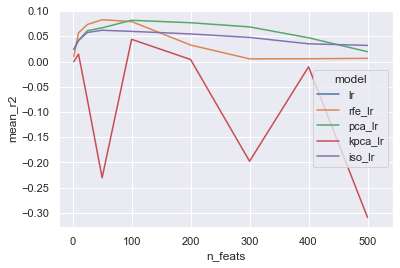

In [11]:
sns.lineplot(data=results, x='n_feats', y='mean_r2', hue='model');

### 3. Regressions

In [17]:
# Load data
df = pd.read_csv('data/reg.csv',  parse_dates=['release']).drop(columns=['release'])

# Preprocess data
df = df.dropna(subset=['popularity'])
df = df.loc[df['popularity']>0]
df = df.dropna(subset=['popularity'])
X = df.drop(columns=['popularity'])
y = stats.boxcox(df['popularity'])[0]
y = pd.Series(y)

print(f'Data: {df.shape[0]} rows, {df.shape[1]} columns')

data shape: 15000 rows, 519 columns


In [21]:
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = {'model':[], 'n_feats':[], 'mean_r2':[], 'mean_mse':[], 'mean_rmse':[], 'mean_mae':[]}

#### Benchmark

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [22]:
st = time.time()
name = 'rfe_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_features_to_select': [50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:58


In [23]:
st = time.time()
name = 'pca_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(svd_solver='arpack', random_state=1)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': [100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:08


#### Elastic net

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elastic%20net#sklearn.linear_model.ElasticNet)

In [24]:
st = time.time()
name = 'rfe_en'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', ElasticNet())
])

parameters = {
    'red__n_features_to_select': [50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:54


In [25]:
st = time.time()
name = 'pca_en'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(svd_solver='arpack', random_state=1)),
    ('mod', ElasticNet())
])

parameters = {
    'red__n_components': [100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:08


#### Polynomial regression

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial%20features#sklearn.preprocessing.PolynomialFeatures)

In [26]:
st = time.time()
name = 'rfe_pr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('poly', PolynomialFeatures(degree=2)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_features_to_select': [50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:06


In [27]:
st = time.time()
name = 'pca_pr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(svd_solver='arpack', random_state=1)),
    ('poly', PolynomialFeatures(degree=2)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': [100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:04:59


#### SVR - support vector regression

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR)

In [28]:
st = time.time()
name = 'rfe_svr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', SVR())
])

parameters = {
    'red__n_features_to_select': [50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:20


In [29]:
st = time.time()
name = 'pca_svr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(svd_solver='arpack', random_state=1)),
    ('mod', SVR())
])

parameters = {
    'red__n_components': [100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:42


#### K-neighbors regression

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=k%20neighbors#sklearn.neighbors.KNeighborsRegressor)

In [30]:
st = time.time()
name = 'rfe_kn'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', KNeighborsRegressor(algorithm='kd_tree'))
])

parameters = {
    'red__n_features_to_select': [50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:53


In [31]:
st = time.time()
name = 'pca_kn'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(svd_solver='arpack', random_state=1)),
    ('mod', KNeighborsRegressor(algorithm='kd_tree'))
])

parameters = {
    'red__n_components': [100]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:17


#### Results

In [37]:
results = pd.DataFrame(scores)
results.to_csv('results/m1_reg_metrics.csv', index=False)
results.style\
    .hide(axis='index')\
    .highlight_quantile(subset=['mean_r2'], q_left=0.9, color='green')\
    .highlight_quantile(subset=['mean_r2'], q_right=0.1, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_left=0.8, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_right=0.2, color='green')

model,n_feats,mean_r2,mean_mse,mean_rmse,mean_mae
rfe_lr,50,0.077833,1.618753,1.272231,1.008344
pca_lr,100,-0.104640,1.943690,1.376401,1.006883
rfe_en,50,-0.000154,1.756091,1.325040,1.051980
pca_en,100,0.017513,1.725020,1.313276,1.042134
rfe_pr,50,-191.939555,343.069791,9.371270,1.212061
pca_pr,100,-94992.349722,167635.798920,257.114405,6.901088
rfe_svr,50,0.095849,1.587236,1.259776,0.993664
pca_svr,100,0.119789,1.545324,1.243007,0.978516
rfe_kn,50,-0.056928,1.855351,1.362036,1.074613
pca_kn,100,-0.023459,1.796896,1.340363,1.052804


### 4. Hyperparamter optimization

In [39]:
# Load data
df = pd.read_csv('data/hyper.csv',  parse_dates=['release']).drop(columns=['release'])

# Preprocess data
df = df.dropna(subset=['popularity'])
df = df.loc[df['popularity']>0]
df = df.dropna(subset=['popularity'])
X = df.drop(columns=['popularity'])
y = stats.boxcox(df['popularity'])[0]
y = pd.Series(y)

print(f'Data: {df.shape[0]} rows, {df.shape[1]} columns')

Hyper data: 15000 rows, 519 columns


In [57]:
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = {'model':[], 'n_feats':[], 'kernel':[], 'C':[], 'epsilon':[], 'mean_r2':[], 'mean_mse':[], 'mean_rmse':[], 'mean_mae':[]}

#### PCA + SVR

In [58]:
st = time.time()
name = 'pca_svr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(svd_solver='arpack', random_state=1)),
    ('mod', SVR())
])
print(pipeline.get_params().keys())

parameters = {
    'red__n_components': [90, 100, 110],
    'mod__kernel': ['linear', 'rbf', 'sigmoid'],
    'mod__C': [0.5, 1],
    'mod__epsilon': [0.5, 1]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['kernel'].append(cv_scores['params'][i]['mod__kernel'])
    scores['C'].append(cv_scores['params'][i]['mod__C'])
    scores['epsilon'].append(cv_scores['params'][i]['mod__epsilon'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

dict_keys(['memory', 'steps', 'verbose', 'sc', 'red', 'mod', 'sc__copy', 'sc__with_mean', 'sc__with_std', 'red__copy', 'red__iterated_power', 'red__n_components', 'red__random_state', 'red__svd_solver', 'red__tol', 'red__whiten', 'mod__C', 'mod__cache_size', 'mod__coef0', 'mod__degree', 'mod__epsilon', 'mod__gamma', 'mod__kernel', 'mod__max_iter', 'mod__shrinking', 'mod__tol', 'mod__verbose'])


/Users/juliet/Documents/UGENT/2021-2022/big_data/practicals/venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


runtime: 0:57:03


#### Results

In [60]:
results = pd.DataFrame(scores)
results.to_csv('results/m1_hyper_metrics.csv', index=False)
results.style\
    .hide(axis='index')\
    .highlight_quantile(subset=['mean_r2'], q_left=0.95, color='green')\
    .highlight_quantile(subset=['mean_r2'], q_right=0.05, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_left=0.95, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_right=0.05, color='green')

model,n_feats,kernel,C,epsilon,mean_r2,mean_mse,mean_rmse,mean_mae
pca_svr,90,linear,0.500000,0.500000,0.088794,1.588993,1.260352,0.996886
pca_svr,100,linear,0.500000,0.500000,0.080661,1.603457,1.265913,0.997060
pca_svr,110,linear,0.500000,0.500000,0.072940,1.617250,1.271203,0.997767
pca_svr,90,rbf,0.500000,0.500000,0.138218,1.503012,1.225749,0.971186
pca_svr,100,rbf,0.500000,0.500000,0.138357,1.502751,1.225649,0.971541
pca_svr,110,rbf,0.500000,0.500000,0.138088,1.503158,1.225827,0.971569
pca_svr,90,sigmoid,0.500000,0.500000,-285.222510,501.116698,22.105329,7.361539
pca_svr,100,sigmoid,0.500000,0.500000,-263.270019,462.747651,21.232819,7.008825
pca_svr,110,sigmoid,0.500000,0.500000,-243.146079,427.478129,20.398581,6.714559
pca_svr,90,linear,0.500000,1.000000,0.092966,1.581709,1.257484,0.997639


### 5. Final model

In [4]:
# Load data
df_train = pd.read_csv('data/hyper.csv',  parse_dates=['release']).drop(columns=['release'])
df_test = pd.read_csv('data/test.csv',  parse_dates=['release']).drop(columns=['release'])
df_test = df_test.sample(n=5000, random_state=1)

# Preprocess data
df_train = df_train.dropna(subset=['popularity'])
df_test = df_test.dropna(subset=['popularity'])

df_train = df_train.loc[df_train['popularity']>0]
df_train = df_train.dropna(subset=['popularity'])
df_test = df_test.loc[df_test['popularity']>0]
df_test = df_test.dropna(subset=['popularity'])

X_train = df_train.drop(columns=['popularity'])
X_test = df_test.drop(columns=['popularity'])
y_train = stats.boxcox(df_train['popularity'])[0]
y_test = stats.boxcox(df_test['popularity'])[0]

print(f'Data train: {df_train.shape[0]} rows, {df_train.shape[1]} columns')
print(f'Data test: {df_test.shape[0]} rows, {df_test.shape[1]} columns')

Data train: 15000 rows, 519 columns
Data test: 5000 rows, 519 columns


In [7]:
pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(n_components=100, svd_solver='arpack', random_state=1)),
    ('mod', SVR(kernel='rbf', C=1, epsilon=0.5))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

r2 = round(sk_metrics.r2_score(y_test, y_pred), 6)
mse = round(sk_metrics.mean_squared_error(y_test, y_pred), 6)
mae = round(sk_metrics.mean_absolute_error(y_test, y_pred), 6)
print(f'Final model: R2: {r2}, MSE: {mse}, MAE:{mae}')

Final model: R2: (0.122519,), MSE: (1.609405,), MAE:(1.011663,)
